In [3]:
import pandas as pd
import regex as re
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import seaborn as sns

In [4]:
tk = TweetTokenizer()

In [5]:
df = pd.read_csv('sentiment_train.csv')

In [6]:
def preprocess(x):
    # x: raw input text
    x = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', x)  # removing website URLs
    x = re.sub(r'http\S+', '', x)   
    x = re.sub('@[^\s]+', '', x)   # removing usernames
    return x  # preprocessed text is returned

In [7]:
df['Text'] = df['5'].apply(lambda x: preprocess(x))
df['label'] = df['0']
df = df.drop(['0', '1', '2', '3', '4', '5'], axis = 1)   # these columns are not important anymore

In [8]:
total_pos = 0
total_neg = 0
total_neu = 0
word_counts = {}

for index, row in df.iterrows():
    words = tk.tokenize(row['Text'])    # get list of words by tokenizing text field
    for word in words:
        word = word.lower()
        if word not in word_counts:
            word_counts[word] = [0,0,0]
        if row['label'] == 4:          # word given positive label
            word_counts[word][0] += 1  
            total_pos += 1
        elif row['label'] == 0:        # word given negative label
            word_counts[word][1] += 1
            total_neg += 1
        elif row['label'] == 2:        # word given neutral label
            word_counts[word][2] += 1
            total_neu += 1
vocab = list(word_counts.keys())   # vocabulary with all unique words

In [10]:
import pickle
a_file = open("naive_bayes.pkl", "wb")
pickle.dump(word_counts, a_file)
a_file.close()

In [ ]:
test = pd.read_csv('sentiment_test.csv')

In [ ]:
def probability(count_word, count_total, len_vocab):  # probability formula with add 1 smoothing
    # count_word: number of occurences of word given label instance
    # count_total: total number of occurences of given label
    # len_vocab: total number of words in vocabulary
    return (count_word + 1)/(count_total + len_vocab)

In [ ]:
test['Text'] = test['5'].apply(lambda x: preprocess(x))
test['label'] = test['0']
test = test.drop(['0', '1', '2', '3', '4', '5'], axis = 1)   # these columns are not important anymore

In [10]:
len_vocab = len(vocab)
y_actual = test['label']
y_pred = []

In [11]:
for index, row in test.iterrows():
    words = tk.tokenize(row['Text'])    # get list of words by tokenizing text field
    pos = 1
    neg = 1
    neu = 1
    for word in words:
        word = word.lower()
        if word in word_counts:   # final probability is product of probabilities for each word
            pos *= probability(word_counts[word][0], total_pos, len_vocab)
            neg *= probability(word_counts[word][1], total_neg, len_vocab)
            neu *= probability(word_counts[word][2], total_neu, len_vocab)
        else:
            pos *= probability(0, total_pos, len_vocab)  # if given word is not present then count_word attribute 
            neg *= probability(0, total_neg, len_vocab)  # in probability becomes 0
            neu *= probability(0, total_neu, len_vocab)
    d = {'pos': pos, 'neg': neg, 'neu': neu}
    max_sentiment = max(d, key=d.get)   # get max probability sentiment 
    if max_sentiment == 'pos':
        y_pred.append(4)
    elif max_sentiment == 'neg':
        y_pred.append(0)
    else:
        y_pred.append(2)

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(y_actual, y_pred)

0.78108125

In [13]:
def getConfusionMatrix(y_pred, y_test):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(y_test)):
        if(y_test[i] == 4 and y_pred[i] == 4):
            tp += 1
        if(y_test[i] == 4 and y_pred[i] == 0):
            fn += 1
        if(y_test[i] == 0 and y_pred[i] == 4):
            fp += 1
        if(y_test[i] == 0 and y_pred[i] == 0):
            tn += 1
    conf_mat = np.array([
            [tp, fn],
            [fp, tn]
        ])
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    if tp+fp == 0:
        precision_pos = 0
    else:
        precision_pos = tp/(tp+fp)

    if tn+fn == 0:
        precision_neg = 0
    else:
        precision_neg = tn/(tn+fn)

    if tp+fn == 0:
        recall_pos = 0
    else:
        recall_pos = tp/(tp+fn)

    if tn+fp == 0:
        recall_neg = 0
    else:
        recall_neg = tn/(tn+fp)

    precision = (precision_pos + precision_neg)/2
    recall = (recall_pos + recall_neg)/2

    if precision_pos + recall_pos == 0:
        f_pos = 0
    else:
        f_pos = 2*(precision_pos * recall_pos)/(precision_pos + recall_pos)

    if precision_neg + recall_neg == 0:
        f_neg = 0
    else:
        f_neg = 2*(precision_neg * recall_neg)/(precision_neg + recall_neg)

    f = (f_pos + f_neg)/2
#         return accuracy, precision, recall, f
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F-score:", f)
    labels = ["Positive", "Negative"]
    ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    ax.set(title="Confusion Matrix",
      xlabel="Predicted",
      ylabel="Gold Standard")

Accuracy: 0.7830159519145221
Precision: 0.7837406264880169
Recall: 0.783080401364769
F-score: 0.7829025154603428


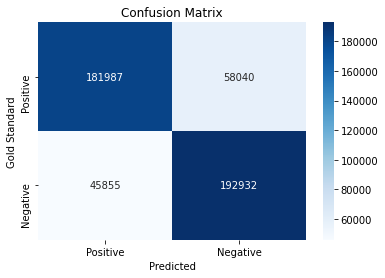

In [14]:
getConfusionMatrix(y_pred, y_actual)